In [2]:
import sqlite3
import pandas as pd
import re

# ----------------------------------------------------------------------
# 1. VERİ TABANI BAĞLANTISI VE VERİ ÇEKME
# ----------------------------------------------------------------------
DB_NAME = 'TrendyolProduct.sqlite3'

try:
    conn = sqlite3.connect(DB_NAME)
    
    # SQL sorgusu ile iki tabloyu birleştirerek veriyi çekme
    query = """
    SELECT 
        T1.Comment_Content, 
        T1.Comment_Evaluation, 
        T2.Product_Name,
        T2.Product_Brand
    FROM 
        TBL_Comment T1
    INNER JOIN 
        TBL_Product T2 ON T1.Product_Id = T2.Product_Id;
    """
    
    # Pandas DataFrame'e yükleme
    df = pd.read_sql_query(query, conn)
    
    conn.close()
    
    print(f"Başlangıçta çekilen toplam yorum sayısı: {len(df)}")

except sqlite3.Error as e:
    print(f"Veri tabanı hatası oluştu: {e}")
    exit()

# ----------------------------------------------------------------------
# 2. YEŞİL FİLTRELEME
# ----------------------------------------------------------------------

# Belirlenen Türkçe Yeşil Anahtar Kelimeler
# Bu kelimelerin her varyasyonunu yakalamak için kökleri kullanıyoruz.
# Örneğin, 'geri dönüştür' -> geri dönüştürülmüş, geri dönüşüm, vb.
yesil_anahtar_kelimeler = [
    'organik', 
    'sürdürülebilir', 
    'geri dönüştür', 
    'eko',        # eko-dostu, ekolojik
    'doğa dostu', # doğa dostu
    'doğal',
    'pamuk'       # Özellikle %100 pamuklu ürünler de buraya dahil edilebilir
]

# Regex paterni oluşturma: '|' operatörü ile 'VEYA' anlamına gelir.
# re.IGNORECASE (re.I) büyük/küçük harf duyarlılığını kaldırır.
pattern = '|'.join(yesil_anahtar_kelimeler)

# Filtreleme koşulunu belirleme:
# 1. Product_Name'de yeşil kelime geçiyor VEYA
# 2. Comment_Content'da yeşil kelime geçiyor.
# NaN değerleri string'e dönüştürerek hatayı önlüyoruz.
condition_name = df['Product_Name'].astype(str).str.contains(pattern, flags=re.I, regex=True)
condition_comment = df['Comment_Content'].astype(str).str.contains(pattern, flags=re.I, regex=True)

# İki koşuldan herhangi birini sağlayan satırları filtreleme
df_yesil = df[condition_name | condition_comment]

# ----------------------------------------------------------------------
# 3. SONUÇLARI GÖSTERME
# ----------------------------------------------------------------------

print("\n-----------------------------------------------------")
print(f"Filtreleme sonrası 'Yeşil Duyarlılık' içeren toplam yorum sayısı: {len(df_yesil)}")
print("-----------------------------------------------------")

print("\nYeşil Veri Setinin (df_yesil) İlk 5 Satırı:\n")
print(df_yesil[['Product_Name', 'Comment_Content', 'Comment_Evaluation']].head())

Başlangıçta çekilen toplam yorum sayısı: 43923

-----------------------------------------------------
Filtreleme sonrası 'Yeşil Duyarlılık' içeren toplam yorum sayısı: 5293
-----------------------------------------------------

Yeşil Veri Setinin (df_yesil) İlk 5 Satırı:

                                        Product_Name  \
0  Erkek %100 Pamuk Koyu Vizon Polo Yaka Düz T-sh...   
1  Erkek %100 Pamuk Koyu Vizon Polo Yaka Düz T-sh...   
2  Erkek %100 Pamuk Koyu Vizon Polo Yaka Düz T-sh...   
3  Erkek %100 Pamuk Koyu Vizon Polo Yaka Düz T-sh...   
4  Erkek %100 Pamuk Koyu Vizon Polo Yaka Düz T-sh...   

                                     Comment_Content  Comment_Evaluation  
0                 Babam için almıştım aşırııı güzell                   5  
1                  Dokusu çok güzel kalitesi çok iyi                   5  
2  renk ve kalite çok güzel AVVA sonuçta indirimd...                   5  
3                                 Çok beğendim güzel                   5  
4              

In [3]:
import sqlite3
import pandas as pd
import re
import numpy as np

# ----------------------------------------------------------------------
# 1. VERİ YÜKLEME VE FİLTRELEME (Önceki Adımı Tekrarlama)
# ----------------------------------------------------------------------
DB_NAME = 'TrendyolProduct.sqlite3'
try:
    conn = sqlite3.connect(DB_NAME)
    query = """
    SELECT 
        T1.Comment_Content, 
        T1.Comment_Evaluation, 
        T2.Product_Name,
        T2.Product_Brand
    FROM 
        TBL_Comment T1
    INNER JOIN 
        TBL_Product T2 ON T1.Product_Id = T2.Product_Id;
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
except sqlite3.Error as e:
    print(f"Veri tabanı hatası oluştu: {e}")
    exit()

yesil_anahtar_kelimeler = ['organik', 'sürdürülebilir', 'geri dönüştür', 'eko', 'doğa dostu', 'doğal', 'pamuk']
pattern = '|'.join(yesil_anahtar_kelimeler)
condition_name = df['Product_Name'].astype(str).str.contains(pattern, flags=re.I, regex=True)
condition_comment = df['Comment_Content'].astype(str).str.contains(pattern, flags=re.I, regex=True)
df_yesil = df[condition_name | condition_comment].copy() # copy() added for good practice

# ----------------------------------------------------------------------
# 2. METİN TEMİZLEME FONKSİYONU
# ----------------------------------------------------------------------

def clean_text(text):
    """Metin verilerini temizleme, küçük harfe çevirme ve Türkçe karakter hatalarını giderme."""
    text = str(text)
    
    # 1. Yaygın bozuk Türkçe karakterleri düzeltme (Örn: Ã§ -> ç)
    text = text.replace('Ä±', 'ı').replace('Ã§', 'ç').replace('ÅŸ', 'ş')
    text = text.replace('Ã¼', 'ü').replace('ÄŸ', 'ğ').replace('Ã¶', 'ö')
    text = text.replace('ÅŸ', 'ş').replace('Ã¢', 'a').replace('â€™', '') # Diğer yaygın hatalar
    
    # 2. Tüm metni küçük harfe çevirme
    text = text.lower()
    
    # 3. Noktalama işaretlerini, sayıları ve alfanümerik olmayan karakterleri kaldırma
    # Sadece Türkçe ve İngilizce harfleri, sayıları (önerilir, bazı yorumlarda puan geçebilir) ve boşlukları koruma
    # Ancak "Yeşil Duygu Analizi" için sadece harflere odaklanmak daha iyidir:
    text = re.sub(r'[^a-zığüşöç\s]', '', text) 
    
    # 4. Birden fazla boşluğu tek boşluğa indirgeme ve baştaki/sondaki boşlukları kaldırma
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# ----------------------------------------------------------------------
# 3. UYGULAMA VE KARŞILAŞTIRMA
# ----------------------------------------------------------------------

# Temizleme işlevini yorum içeriği sütununa uygulama
df_yesil['Cleaned_Content'] = df_yesil['Comment_Content'].apply(clean_text)

# Karşılaştırma için ilk 5 satırı gösterme
print("\n-----------------------------------------------------")
print("Temizleme Öncesi ve Sonrası Karşılaştırma (İlk 5 Yorum)")
print("-----------------------------------------------------")
comparison_df = df_yesil[['Comment_Content', 'Cleaned_Content']].head()
print(comparison_df)

# Temizlenmiş veriyi bir sonraki analiz adımı için kaydetme
df_yesil.to_csv("trendyol_yesil_yorumlar_cleaned.csv", index=False)
print("\nTemizlenmiş 'Yeşil Yorumlar' veri seti 'trendyol_yesil_yorumlar_cleaned.csv' olarak kaydedildi.")


-----------------------------------------------------
Temizleme Öncesi ve Sonrası Karşılaştırma (İlk 5 Yorum)
-----------------------------------------------------
                                     Comment_Content  \
0                 Babam için almıştım aşırııı güzell   
1                  Dokusu çok güzel kalitesi çok iyi   
2  renk ve kalite çok güzel AVVA sonuçta indirimd...   
3                                 Çok beğendim güzel   
4                                       Güzel tişört   

                                     Cleaned_Content  
0                 babam için almıştım aşırııı güzell  
1                  dokusu çok güzel kalitesi çok iyi  
2  renk ve kalite çok güzel avva sonuçta indirimd...  
3                                 çok beğendim güzel  
4                                       güzel tişört  

Temizlenmiş 'Yeşil Yorumlar' veri seti 'trendyol_yesil_yorumlar_cleaned.csv' olarak kaydedildi.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------------------------------------
# 1. VERİYİ YÜKLEME
# ----------------------------------------------------------------------
FILE_NAME = 'trendyol_yesil_yorumlar_cleaned.csv'
try:
    df = pd.read_csv(FILE_NAME)
    print(f"'{FILE_NAME}' dosyası başarıyla yüklendi. Toplam kayıt: {len(df)}")
except FileNotFoundError:
    print(f"Hata: '{FILE_NAME}' dosyası bulunamadı. Lütfen dosyanın mevcut olduğundan emin olun.")
    exit()

# ----------------------------------------------------------------------
# 2. DUYGU ETİKETLEME FONKSİYONU
# ----------------------------------------------------------------------

def score_to_sentiment(score):
    """5'li değerlendirme puanını Duygu Etiketine dönüştürür."""
    if score >= 4:
        return 'Pozitif'
    elif score == 3:
        return 'Nötr'
    elif score <= 2:
        return 'Negatif'
    return 'Bilinmiyor'

# Duygu Etiketleme fonksiyonunu uygulama
df['Sentiment_Label'] = df['Comment_Evaluation'].apply(score_to_sentiment)

# ----------------------------------------------------------------------
# 3. DAĞILIM ANALİZİ VE GÖRSELLEŞTİRME
# ----------------------------------------------------------------------

# Duygu Etiketlerinin sayısını hesaplama
sentiment_counts = df['Sentiment_Label'].value_counts()
sentiment_distribution = pd.DataFrame(sentiment_counts).reset_index()
sentiment_distribution.columns = ['Sentiment', 'Count']
sentiment_distribution['Percentage'] = (sentiment_distribution['Count'] / sentiment_distribution['Count'].sum()) * 100

print("\n-----------------------------------------------------")
print("Yeşil Duyarlılık Yorumlarının Duygu Dağılımı (Sayı ve Yüzde)")
print("-----------------------------------------------------")
print(sentiment_distribution)

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_distribution, palette=['#4CAF50', '#FFC107', '#F44336'], order=['Pozitif', 'Nötr', 'Negatif'])
plt.title('Yeşil Duyarlılık Yorumlarının Duygu Dağılımı', fontsize=14)
plt.xlabel('Duygu Etiketi', fontsize=12)
plt.ylabel('Yorum Sayısı', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.savefig('sentiment_distribution_bar_chart.png')
plt.close()

# Güncellenmiş DataFrame'i (etiket eklenmiş) bir sonraki adım için kaydetme
df.to_csv("trendyol_yesil_yorumlar_labeled.csv", index=False)
print("\nEtiketlenmiş 'Yeşil Yorumlar' veri seti 'trendyol_yesil_yorumlar_labeled.csv' olarak kaydedildi.")

'trendyol_yesil_yorumlar_cleaned.csv' dosyası başarıyla yüklendi. Toplam kayıt: 5293

-----------------------------------------------------
Yeşil Duyarlılık Yorumlarının Duygu Dağılımı (Sayı ve Yüzde)
-----------------------------------------------------
  Sentiment  Count  Percentage
0   Pozitif   4479   84.621198
1   Negatif    443    8.369545
2      Nötr    371    7.009258


C:\Users\efeoz\AppData\Local\Temp\ipykernel_24260\2768807027.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Count', data=sentiment_distribution, palette=['#4CAF50', '#FFC107', '#F44336'], order=['Pozitif', 'Nötr', 'Negatif'])



Etiketlenmiş 'Yeşil Yorumlar' veri seti 'trendyol_yesil_yorumlar_labeled.csv' olarak kaydedildi.


In [7]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split

# NLTK Türkçe stop words listesini indirme (Gerekiyorsa)
try:
    turkish_stopwords = stopwords.words('turkish')
except LookupError:
    nltk.download('stopwords')
    turkish_stopwords = stopwords.words('turkish')

# ----------------------------------------------------------------------
# 1. VERİYİ YÜKLEME
# ----------------------------------------------------------------------
FILE_NAME = 'trendyol_yesil_yorumlar_labeled.csv'
df = pd.read_csv(FILE_NAME)

# ----------------------------------------------------------------------
# 2. STOP WORD KALDIRMA VE FREKANS ANALİZİ FONKSİYONU
# ----------------------------------------------------------------------

def remove_stopwords_and_tokenize(text, stop_words):
    """Metni kelimelere ayırır ve durma kelimelerini kaldırır."""
    if pd.isna(text):
        return []
    # clean_text fonksiyonunda zaten küçük harf ve noktalama temizliği yapılmıştı
    words = text.split()
    return [word for word in words if word not in stop_words]

def get_word_frequency(df_subset, column_name, top_n=20):
    """Belirli bir alt kümedeki en sık geçen kelimeleri hesaplar."""
    all_words = []
    for text_list in df_subset[column_name]:
        all_words.extend(text_list)
        
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Cleaned_Content üzerinde stop word kaldırma
df['Tokenized_Content'] = df['Cleaned_Content'].apply(lambda x: remove_stopwords_and_tokenize(x, turkish_stopwords))

# ----------------------------------------------------------------------
# 3. POZİTİF VE NEGATİF KELİME FREKANSI ANALİZİ
# ----------------------------------------------------------------------

df_pozitif = df[df['Sentiment_Label'] == 'Pozitif']
df_negatif = df[df['Sentiment_Label'] == 'Negatif']

top_pozitif_words = get_word_frequency(df_pozitif, 'Tokenized_Content')
top_negatif_words = get_word_frequency(df_negatif, 'Tokenized_Content')

print("\n-----------------------------------------------------")
print("I. Pozitif Yorumlarda En Sık Kullanılan Kelimeler (TOP 20)")
print("-----------------------------------------------------")
for word, count in top_pozitif_words:
    print(f"  {word}: {count}")

print("\n-----------------------------------------------------")
print("II. Negatif Yorumlarda En Sık Kullanılan Kelimeler (TOP 20)")
print("-----------------------------------------------------")
for word, count in top_negatif_words:
    print(f"  {word}: {count}")

# ----------------------------------------------------------------------
# 4. MODELLEME İÇİN VERİ AYIRMA (Eğitim/Test Setleri)
# ----------------------------------------------------------------------

X = df['Cleaned_Content'] # Girdi (yorum metni)
y = df['Sentiment_Label'] # Çıktı (duygu etiketi)

# Veriyi %80 eğitim ve %20 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n-----------------------------------------------------")
print("Modelleme İçin Veri Hazırlığı Tamamlandı")
print("-----------------------------------------------------")
print(f"Eğitim Seti (Yorum): {len(X_train)}")
print(f"Test Seti (Yorum): {len(X_test)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\efeoz\AppData\Roaming\nltk_data...



-----------------------------------------------------
I. Pozitif Yorumlarda En Sık Kullanılan Kelimeler (TOP 20)
-----------------------------------------------------
  güzel: 1783
  ürün: 899
  bir: 806
  kaliteli: 704
  aldım: 630
  tam: 568
  beden: 503
  rahat: 323
  gayet: 319
  cok: 310
  kumaşı: 287
  oldu: 284
  beğendim: 281
  harika: 280
  iyi: 271
  ederim: 268
  kalitesi: 265
  tavsiye: 255
  guzel: 201
  geldi: 189

-----------------------------------------------------
II. Negatif Yorumlarda En Sık Kullanılan Kelimeler (TOP 20)
-----------------------------------------------------
  ürün: 92
  beden: 71
  değil: 70
  bir: 69
  iade: 64
  geldi: 55
  güzel: 47
  büyük: 46
  beğenmedim: 31
  dar: 31
  kötü: 26
  aldım: 26
  cok: 26
  kumaşı: 26
  yok: 24
  var: 24
  s: 22
  kaliteli: 20
  göre: 20
  bol: 20

-----------------------------------------------------
Modelleme İçin Veri Hazırlığı Tamamlandı
-----------------------------------------------------
Eğitim Seti (Yorum)

[nltk_data]   Unzipping corpora\stopwords.zip.


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# ----------------------------------------------------------------------
# 1. VERİYİ YÜKLEME VE AYIRMA (Önceki Adımdan)
# ----------------------------------------------------------------------
FILE_NAME = 'trendyol_yesil_yorumlar_labeled.csv'
df = pd.read_csv(FILE_NAME)

X = df['Cleaned_Content'].fillna('') # Boş metinleri boş string ile doldurma
y = df['Sentiment_Label']

# Veriyi %80 eğitim ve %20 test olarak ayırma (önceki adımla aynı)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# ----------------------------------------------------------------------
# 2. VEKTÖRLEŞTİRME (TF-IDF)
# ----------------------------------------------------------------------

# TF-IDF Vektörleştirici başlatma
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), # Unigram ve bigram'ları kullanma (örn: "çok güzel")
    min_df=5           # En az 5 kez geçen kelimeleri/ikilileri dahil etme
)

# Vektörleştiriciyi sadece eğitim verisi üzerinde eğitme ve dönüştürme
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Test verisini eğitilmiş vektörleyici ile dönüştürme
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\n-----------------------------------------------------")
print(f"TF-IDF Vektörleştirme Tamamlandı. Özellik Sayısı (feature count): {X_train_tfidf.shape[1]}")
print("-----------------------------------------------------")

# ----------------------------------------------------------------------
# 3. MODEL EĞİTİMİ (Lojistik Regresyon)
# ----------------------------------------------------------------------

# Lojistik Regresyon modelini başlatma
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced' # Dengesiz veri setini dengelemek için ağırlıklandırma
)

# Modeli eğitme
lr_model.fit(X_train_tfidf, y_train)

# ----------------------------------------------------------------------
# 4. MODEL PERFORMANSI DEĞERLENDİRMESİ
# ----------------------------------------------------------------------

# Test seti üzerinde tahmin yapma
y_pred = lr_model.predict(X_test_tfidf)

# Doğruluk (Accuracy)
accuracy = accuracy_score(y_test, y_pred)

print("\n-----------------------------------------------------")
print("Yeşil Duygu Analizi Modeli Performans Raporu (Lojistik Regresyon)")
print("-----------------------------------------------------")
print(f"Genel Doğruluk (Accuracy): {accuracy:.4f}\n")
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Nötr', 'Pozitif']))


-----------------------------------------------------
TF-IDF Vektörleştirme Tamamlandı. Özellik Sayısı (feature count): 1264
-----------------------------------------------------

-----------------------------------------------------
Yeşil Duygu Analizi Modeli Performans Raporu (Lojistik Regresyon)
-----------------------------------------------------
Genel Doğruluk (Accuracy): 0.8244

              precision    recall  f1-score   support

     Negatif       0.54      0.67      0.60        89
        Nötr       0.25      0.51      0.34        74
     Pozitif       0.97      0.86      0.92       896

    accuracy                           0.82      1059
   macro avg       0.59      0.68      0.62      1059
weighted avg       0.89      0.82      0.85      1059



In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.metrics import classification_report, accuracy_score

# ----------------------------------------------------------------------
# 1. VERİYİ YÜKLEME VE AYIRMA (Önceki Adımları Tekrarlama)
# ----------------------------------------------------------------------
FILE_NAME = 'trendyol_yesil_yorumlar_labeled.csv'
df = pd.read_csv(FILE_NAME)

X = df['Cleaned_Content'].fillna('')
y = df['Sentiment_Label']

# Veriyi %80 eğitim ve %20 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vektörleştirme
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# ----------------------------------------------------------------------
# 2. MODEL EĞİTİMİ (Support Vector Machine - SVC)
# ----------------------------------------------------------------------

# SVC modelini başlatma
# LinearSVC veya Kernel=linear ile yüksek boyutlu verilerde hızlı çalışır
# class_weight='balanced' ile veri dengesizliği yine ele alınır
svc_model = SVC(
    kernel='linear', # Lineer çekirdek (TF-IDF için hızlı ve etkili)
    random_state=42,
    class_weight='balanced'
)

# Modeli eğitme
svc_model.fit(X_train_tfidf, y_train)

# ----------------------------------------------------------------------
# 3. MODEL PERFORMANSI DEĞERLENDİRMESİ
# ----------------------------------------------------------------------

# Test seti üzerinde tahmin yapma
y_pred_svc = svc_model.predict(X_test_tfidf)

# Doğruluk (Accuracy)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print("\n-----------------------------------------------------")
print("Yeşil Duygu Analizi Modeli Performans Raporu (Support Vector Machine - SVC)")
print("-----------------------------------------------------")
print(f"Genel Doğruluk (Accuracy): {accuracy_svc:.4f}\n")
print(classification_report(y_test, y_pred_svc, target_names=['Negatif', 'Nötr', 'Pozitif']))


-----------------------------------------------------
Yeşil Duygu Analizi Modeli Performans Raporu (Support Vector Machine - SVC)
-----------------------------------------------------
Genel Doğruluk (Accuracy): 0.8263

              precision    recall  f1-score   support

     Negatif       0.51      0.60      0.55        89
        Nötr       0.26      0.50      0.34        74
     Pozitif       0.96      0.88      0.92       896

    accuracy                           0.83      1059
   macro avg       0.58      0.66      0.60      1059
weighted avg       0.88      0.83      0.85      1059



In [11]:
# Veri etiketleri Hazırlama


import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Veri setini yükle
df = pd.read_csv("trendyol_yesil_yorumlar_labeled.csv")

# Boş olanları temizle
df = df[['Cleaned_Content', 'Sentiment_Label']].dropna()

# 2) Etiket haritaları
label2id = {'Negatif': 0, 'Nötr': 1, 'Pozitif': 2}
id2label = {v: k for k, v in label2id.items()}

df['label'] = df['Sentiment_Label'].map(label2id)

# 3) Eğitim / test bölme (LR ve SVC ile aynı mantıkta)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

len(train_df), len(test_df)


(4227, 1057)

In [12]:
# 3. Pandas → HuggingFace Dataset, tokenize, BERT’e hazırlık
from datasets import Dataset
from transformers import AutoTokenizer

# HuggingFace Dataset'e çevir
train_ds = Dataset.from_pandas(
    train_df[['Cleaned_Content', 'label']].rename(columns={'Cleaned_Content': 'text'})
)
test_ds = Dataset.from_pandas(
    test_df[['Cleaned_Content', 'label']].rename(columns={'Cleaned_Content': 'text'})
)

# Kullanacağın model (burayı istersen değiştir)
model_name = "dbmdz/bert-base-turkish-cased"
# model_name = "savasy/bert-base-turkish-sentiment-cased"  # ikinci deney için

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tokenized = train_ds.map(tokenize, batched=True)
test_tokenized = test_ds.map(tokenize, batched=True)

# Artık text kolonu BERT için lazım değil
train_tokenized = train_tokenized.remove_columns(['text', '__index_level_0__'])
test_tokenized = test_tokenized.remove_columns(['text', '__index_level_0__'])

train_tokenized.set_format('torch')
test_tokenized.set_format('torch')


Map:   0%|          | 0/4227 [00:00<?, ? examples/s]

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

In [14]:
#4. BERT modelini kur ve Trainer ile eğit
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

# 1) Modeli yükle
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# 2) Metrikler
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")
    f1_weighted = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {
        "accuracy": acc["accuracy"],
        "f1_macro": f1_macro["f1"],
        "f1_weighted": f1_weighted["f1"]
    }

# 3) Eğitim ayarları
training_args = TrainingArguments(
    output_dir="yesil_bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50
)

# 4) Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset

import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ============================================================
# 2) VERİYİ YÜKLE VE ETİKETLERİ SAYISALLAŞTIR
# ============================================================
FILE_NAME = "trendyol_yesil_yorumlar_labeled.csv"

df = pd.read_csv(FILE_NAME)

# Sadece gerekli kolonlar:
df = df[["Cleaned_Content", "Sentiment_Label"]].dropna()

# Etiket haritası (string -> id)
label2id = {"Negatif": 0, "Nötr": 1, "Pozitif": 2}
id2label = {v: k for k, v in label2id.items()}

df["label"] = df["Sentiment_Label"].map(label2id)

# Eğitim / test bölmesi (LR / SVC ile aynı mantık)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Eğitim seti boyutu:", len(train_df))
print("Test seti boyutu:", len(test_df))

# ============================================================
# 3) PANDAS -> HUGGINGFACE DATASET ve TOKENİZASYON
# ============================================================

# HuggingFace Dataset formatına çevir
train_ds = Dataset.from_pandas(
    train_df[["Cleaned_Content", "label"]].rename(columns={"Cleaned_Content": "text"})
)
test_ds = Dataset.from_pandas(
    test_df[["Cleaned_Content", "label"]].rename(columns={"Cleaned_Content": "text"})
)

# Kullanılacak model ismi (BERTurk)
model_name = "dbmdz/bert-base-turkish-cased"
# Eğer ikinci deney yapmak istersen:
# model_name = "savasy/bert-base-turkish-sentiment-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tokenized = train_ds.map(tokenize, batched=True)
test_tokenized = test_ds.map(tokenize, batched=True)

# Artık raw text ve index'e ihtiyacımız yok
cols_to_remove = [c for c in train_tokenized.column_names if c in ["text", "__index_level_0__"]]
train_tokenized = train_tokenized.remove_columns(cols_to_remove)
test_tokenized = test_tokenized.remove_columns(cols_to_remove)

train_tokenized = train_tokenized.with_format("torch")
test_tokenized = test_tokenized.with_format("torch")

# ============================================================
# 4) MODELİ YÜKLE (BERT + Sınıflandırma Kafası)
# ============================================================

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# (Buradaki uyarı normal:
# "Some weights of BertForSequenceClassification were not initialized..."
# Yeni classifier katmanı random başlatılıyor, tam da istediğimiz şey.)

# ============================================================
# 5) METRİKLER (ACCURACY + F1 MACRO / WEIGHTED)
# ============================================================

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")
    f1_weighted = f1_metric.compute(predictions=preds, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "f1_macro": f1_macro["f1"],
        "f1_weighted": f1_weighted["f1"],
    }

# ============================================================
# 6) TRAINING ARGUMENTS (YENİ API)
# ============================================================

training_args = TrainingArguments(
    output_dir="yesil_bert",
    evaluation_strategy="epoch",      # her epoch sonunda eval
    save_strategy="epoch",            # her epoch sonunda model kaydet
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,      # en iyi eval metrikli modeli geri yükle
    metric_for_best_model="f1_macro",
    logging_steps=50
)

# ============================================================
# 7) TRAINER OLUŞTUR VE EĞİT
# ============================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)

trainer.train()

# ============================================================
# 8) TEST PERFORMANSI + CLASSIFICATION REPORT
# ============================================================

print("\n=== Eval Sonuçları (Trainer.evaluate) ===")
eval_results = trainer.evaluate()
print(eval_results)

print("\n=== Ayrıntılı Sınıf Bazlı Rapor (classification_report) ===")
pred_output = trainer.predict(test_tokenized)
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=-1)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Negatif", "Nötr", "Pozitif"]
    )
)

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))

Eğitim seti boyutu: 4227
Test seti boyutu: 1057


Map:   0%|          | 0/4227 [00:00<?, ? examples/s]

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [16]:
!pip uninstall -y transformers
!pip uninstall -y tokenizers
!pip uninstall -y huggingface_hub

!pip install --no-cache-dir "transformers>=4.40.0" "datasets>=2.18.0" "evaluate"


Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1


You can safely remove it manually.


Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.0 MB 4.2 MB/s eta 0:00:03
   ------------------- -------------------- 5.8/12.0 MB 19.6 MB/s eta 0:00:01
   ----------------------------- ---------- 8.9/12.0 MB 17.9 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 16.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/566.1 kB ? eta -:--:--
   ---------------------------------------- 566.1/566.1 kB ? eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 14.0 MB/s eta 0:00:00


In [18]:
# ============================================================
# 0) Gerekli paketler (ilk çalıştırmada)
# ============================================================
!pip install -U "transformers" "datasets" "evaluate" scikit-learn

# ============================================================
# 1) IMPORTLAR
# ============================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset

import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import transformers
print("Transformers version:", transformers.__version__)

# ============================================================
# 2) VERİYİ YÜKLE VE ETİKETLERİ SAYISALLAŞTIR
# ============================================================
FILE_NAME = "trendyol_yesil_yorumlar_labeled.csv"

df = pd.read_csv(FILE_NAME)

# Sadece gerekli kolonlar:
df = df[["Cleaned_Content", "Sentiment_Label"]].dropna()

# Etiket haritası (string -> id)
label2id = {"Negatif": 0, "Nötr": 1, "Pozitif": 2}
id2label = {v: k for k, v in label2id.items()}

df["label"] = df["Sentiment_Label"].map(label2id)

# Eğitim / test bölmesi (LR / SVC ile aynı mantık)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Eğitim seti boyutu:", len(train_df))
print("Test seti boyutu:", len(test_df))

# ============================================================
# 3) PANDAS -> HUGGINGFACE DATASET ve TOKENİZASYON
# ============================================================

# HuggingFace Dataset formatına çevir
train_ds = Dataset.from_pandas(
    train_df[["Cleaned_Content", "label"]].rename(columns={"Cleaned_Content": "text"})
)
test_ds = Dataset.from_pandas(
    test_df[["Cleaned_Content", "label"]].rename(columns={"Cleaned_Content": "text"})
)

# Kullanılacak model ismi (BERTurk)
model_name = "dbmdz/bert-base-turkish-cased"
# İkinci bir deney yapmak istersen:
# model_name = "savasy/bert-base-turkish-sentiment-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tokenized = train_ds.map(tokenize, batched=True)
test_tokenized = test_ds.map(tokenize, batched=True)

# Artık raw text ve varsa index'e ihtiyacımız yok
cols_to_remove = [c for c in train_tokenized.column_names if c in ["text", "__index_level_0__"]]
train_tokenized = train_tokenized.remove_columns(cols_to_remove)
test_tokenized = test_tokenized.remove_columns(cols_to_remove)

train_tokenized = train_tokenized.with_format("torch")
test_tokenized = test_tokenized.with_format("torch")

# ============================================================
# 4) MODELİ YÜKLE (BERT + Sınıflandırma Kafası)
# ============================================================

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# Buradaki uyarı normal:
# "Some weights of BertForSequenceClassification were not initialized..."
# Yeni classifier katmanı random başlatılıyor, yani tam istediğimiz gibi.

# ============================================================
# 5) METRİKLER (ACCURACY + F1 MACRO / WEIGHTED)
# ============================================================

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")
    f1_weighted = f1_metric.compute(predictions=preds, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "f1_macro": f1_macro["f1"],
        "f1_weighted": f1_weighted["f1"],
    }

# ============================================================
# 6) TRAINING ARGUMENTS (MINIMAL – TÜM SÜRÜMLERLE UYUMLU)
# ============================================================

training_args = TrainingArguments(
    output_dir="yesil_bert",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    do_eval=True   # eğitim sırasında eval da yapılacak
)

# ============================================================
# 7) TRAINER OLUŞTUR VE EĞİT
# ============================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)

trainer.train()

# ============================================================
# 8) TEST PERFORMANSI + CLASSIFICATION REPORT
# ============================================================

print("\n=== Eval Sonuçları (Trainer.evaluate) ===")
eval_results = trainer.evaluate()
print(eval_results)

print("\n=== Ayrıntılı Sınıf Bazlı Rapor (classification_report) ===")
pred_output = trainer.predict(test_tokenized)
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=-1)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Negatif", "Nötr", "Pozitif"]
    )
)

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   ----------------------------- ---------- 6.6/8.9 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 21.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Transformers version: 4.57.1
Eğitim seti boyutu: 4227
Test seti boyutu: 1057


Map:   0%|          | 0/4227 [00:00<?, ? examples/s]

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.581500
100,0.380900
150,0.369200
200,0.312500
250,0.321700
300,0.257200
350,0.259800
400,0.251000
450,0.325500
500,0.237600



=== Eval Sonuçları (Trainer.evaluate) ===


{'eval_loss': 0.2703309953212738, 'eval_accuracy': 0.9063386944181646, 'eval_f1_macro': 0.6693596984129249, 'eval_f1_weighted': 0.899369921794393, 'eval_runtime': 5.0145, 'eval_samples_per_second': 210.789, 'eval_steps_per_second': 6.78, 'epoch': 3.0}

=== Ayrıntılı Sınıf Bazlı Rapor (classification_report) ===
              precision    recall  f1-score   support

     Negatif       0.69      0.81      0.75        89
        Nötr       0.38      0.24      0.30        74
     Pozitif       0.96      0.97      0.96       894

    accuracy                           0.91      1057
   macro avg       0.68      0.67      0.67      1057
weighted avg       0.90      0.91      0.90      1057


=== Confusion Matrix ===
[[ 72  10   7]
 [ 25  18  31]
 [  7  19 868]]


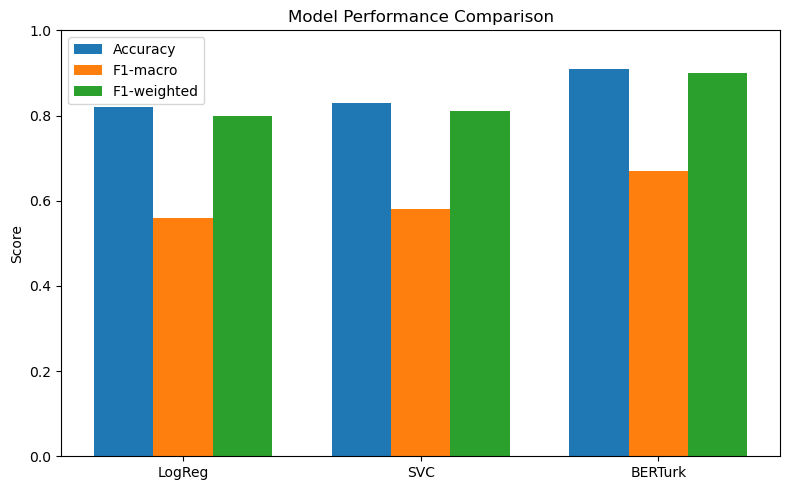

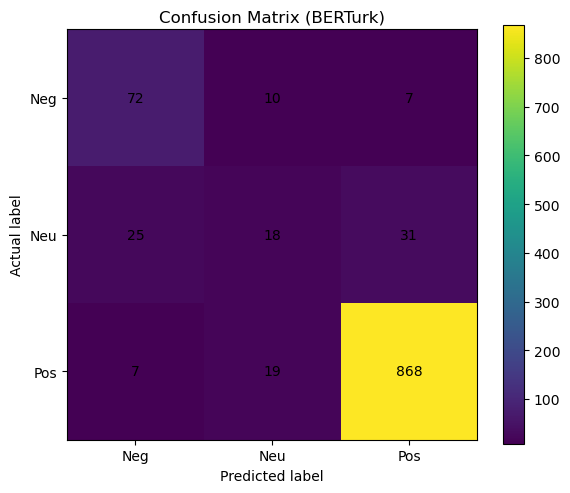

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# Figure 1 – Model Performance Comparison
# ============================================

# Model names
models = ['LogReg', 'SVC', 'BERTurk']

# Metrics (senin sonuçların)
accuracy = [0.82, 0.83, 0.91]
f1_macro = [0.56, 0.58, 0.67]
f1_weighted = [0.80, 0.81, 0.90]

x = np.arange(len(models))
width = 0.25  # bar width

plt.figure(figsize=(8, 5))

plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x,         f1_macro, width, label='F1-macro')
plt.bar(x + width, f1_weighted, width, label='F1-weighted')

plt.xticks(x, models)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()

# Kaydetmek istersen:
plt.savefig("model_performance.png", dpi=300)
plt.show()


# ============================================
# Figure 2 – Confusion Matrix for BERTurk
# ============================================

# Confusion matrix values (senin çıktın)
# rows: actual [Neg, Neu, Pos]
# cols: predicted [Neg, Neu, Pos]
cm = np.array([
    [72, 10,  7],   # Actual Negative
    [25, 18, 31],   # Actual Neutral
    [7,  19, 868]   # Actual Positive
])

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.colorbar()

plt.xticks([0, 1, 2], ['Neg', 'Neu', 'Pos'])
plt.yticks([0, 1, 2], ['Neg', 'Neu', 'Pos'])
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix (BERTurk)")

# Her hücreye sayı yazdırmak istersen:
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha='center', va='center')

plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()
